# homuncu_loc image viewer

In [3]:
import napari
from skimage import io
import btrack
import os
from tqdm.auto import tqdm
import numpy as np
import btrack
from glob import glob
from homuncu_loc.dataio import find_files_with_basename #, ID_extractor

#### Define image fn 

In [ ]:
image_fn = '/run/user/30046150/gvfs/smb-share:server=data2.thecrick.org,share=lab-gutierrezm/home/shared/Lung on Chip/image analysis_Nathan/Job_Mtb area/run3/23-03-002/20230801_20X_23-03-002A5_DAPI_NKX201_PDPN_ZO-1_Multichannel Z-Stack_20230801_1441.tif'

#### Or search for image basename in directory

In [4]:
image_basename = '20230714_20X_23-02-104A4_Multichannel Z-Stack_20230714_1340.tif'
start_directory = '/run/user/30046150/gvfs/smb-share:server=data2.thecrick.org,share=lab-gutierrezm/home/shared/Lung on Chip/homuncu_loc_image_analysis'

In [6]:
image_fn_results = find_files_with_basename(image_basename, start_directory)
print(image_fn_results)

['/run/user/30046150/gvfs/smb-share:server=data2.thecrick.org,share=lab-gutierrezm/home/shared/Lung on Chip/homuncu_loc_image_analysis/iAT1_iAT2_iVEC_macrophage_experiments/DAPI_ZO1_CD16_MTB/images/20230714_20X_23-02-104A4_Multichannel Z-Stack_20230714_1340.tif']


In [7]:
image_fn = image_fn_results[0]

In [10]:
%%time
# load into memory
image = io.imread(image_fn)
# if using dask
# from dask_image.imread import imread
# image = imread(image_fn)
# print(image.shape)
# image = image.reshape((61, 4, 2304, 2304))

CPU times: user 1.53 s, sys: 3.63 s, total: 5.17 s
Wall time: 1min 8s


In [12]:
image.shape

(93, 2304, 2304, 4)

#### Now do the same for the tracking file

In [8]:
sc_labels = glob(image_fn.replace('images', 'sc_analyses').replace('.tif', '*'))

In [12]:
sc_labels

['/run/user/30046150/gvfs/smb-share:server=data2.thecrick.org,share=lab-gutierrezm/home/shared/Lung on Chip/homuncu_loc_image_analysis/iAT1_iAT2_iVEC_macrophage_experiments/DAPI_ZO1_CD16_MTB/sc_analyses/20230714_20X_23-02-104A4_Multichannel Z-Stack_20230714_1340_sc_results.csv',
 '/run/user/30046150/gvfs/smb-share:server=data2.thecrick.org,share=lab-gutierrezm/home/shared/Lung on Chip/homuncu_loc_image_analysis/iAT1_iAT2_iVEC_macrophage_experiments/DAPI_ZO1_CD16_MTB/sc_analyses/20230714_20X_23-02-104A4_Multichannel Z-Stack_20230714_1340_z_tracks_masks.h5',
 '/run/user/30046150/gvfs/smb-share:server=data2.thecrick.org,share=lab-gutierrezm/home/shared/Lung on Chip/homuncu_loc_image_analysis/iAT1_iAT2_iVEC_macrophage_experiments/DAPI_ZO1_CD16_MTB/sc_analyses/20230714_20X_23-02-104A4_Multichannel Z-Stack_20230714_1340_z_tracks_masks_d100.h5']

In [ ]:
tracks_basename = '20230801_20X_23-03-011B5_DAPI_NKX2-1_PDPN_ZO-1_Multichannel Z-Stack_20230801_1434_sc_data.h5'
tracks_fn_results = find_files_with_basename(tracks_basename, start_directory)
if len(tracks_fn_results) > 1:
        raise ValueError("Found more than one matching file. Please ensure only one target file exists or refine your search criteria.")
print(tracks_fn_results)

In [13]:
tracks_fn =   '/run/user/30046150/gvfs/smb-share:server=data2.thecrick.org,share=lab-gutierrezm/home/shared/Lung on Chip/homuncu_loc_image_analysis/iAT1_iAT2_iVEC_macrophage_experiments/DAPI_ZO1_CD16_MTB/sc_analyses/20230714_20X_23-02-104A4_Multichannel Z-Stack_20230714_1340_z_tracks_masks.h5'
#tracks_fn =  tracks_fn_results[0]

#### Now load the segmentation and z-tracks

In [14]:
with btrack.io.HDF5FileHandler(tracks_fn, 'r', obj_type='obj_type_1') as reader:
    segmentation = reader.segmentation
    tracks = [t for t in reader.tracks if len(t) >= 3]

[INFO][2023/09/05 11:07:20 AM] Opening HDF file: /run/user/30046150/gvfs/smb-share:server=data2.thecrick.org,share=lab-gutierrezm/home/shared/Lung on Chip/homuncu_loc_image_analysis/iAT1_iAT2_iVEC_macrophage_experiments/DAPI_ZO1_CD16_MTB/sc_analyses/20230714_20X_23-02-104A4_Multichannel Z-Stack_20230714_1340_z_tracks_masks.h5...
[INFO][2023/09/05 11:07:23 AM] Loading segmentation (93, 2304, 2304)
[INFO][2023/09/05 11:07:23 AM] Loading tracks/obj_type_1
[INFO][2023/09/05 11:07:23 AM] Loading LBEP/obj_type_1
[INFO][2023/09/05 11:07:23 AM] Loading objects/obj_type_1 (3482, 5) (3482 filtered: None)
[INFO][2023/09/05 11:07:23 AM] Closing HDF file: /run/user/30046150/gvfs/smb-share:server=data2.thecrick.org,share=lab-gutierrezm/home/shared/Lung on Chip/homuncu_loc_image_analysis/iAT1_iAT2_iVEC_macrophage_experiments/DAPI_ZO1_CD16_MTB/sc_analyses/20230714_20X_23-02-104A4_Multichannel Z-Stack_20230714_1340_z_tracks_masks.h5


In [15]:
napari_tracks, _, _ = btrack.utils.tracks_to_napari(tracks, ndim = 2)

In [16]:
recolored_segmentation = btrack.utils.update_segmentation(segmentation, tracks, color_by='ID')

In [35]:
viewer = napari.Viewer(title = image_basename)

viewer.add_image(image, channel_axis = -1)
# viewer.add_labels(segmentation, visible = False)
# viewer.add_labels(recolored_segmentation)
# viewer.add_tracks(napari_tracks)

[<Image layer 'Image' at 0x7f933deecd90>,
 <Image layer 'Image [1]' at 0x7f93206ddc10>,
 <Image layer 'Image [2]' at 0x7f932069ef70>,
 <Image layer 'Image [3]' at 0x7f9320650c70>]

In [18]:
print()

In [21]:
cd_frame = image[24,...,2]

In [22]:
viewer = napari.Viewer(title = 'mphi seg dev')

viewer.add_image(cd_frame)
# viewer.add_labels(segmentation, visible = False)
# viewer.add_labels(recolored_segmentation)
# viewer.add_tracks(napari_tracks)

<Image layer 'cd_frame' at 0x7fdc4d6bce80>

In [76]:
# print gpu information
!nvcc --version
!nvidia-smi

# load cellpose
from cellpose import core, utils, models, metrics
import matplotlib.pyplot as plt 
from skimage.morphology import remove_small_objects

# check to see if GPU can be used
use_GPU = core.use_gpu()
yn = ['NO', 'YES']
print(f'>>> GPU activated? {yn[use_GPU]}')

# define segmentation model parameters
model = models.Cellpose(gpu=use_GPU, 
                        model_type='cyto') # cytoplasmic segmentation 
channels = [0,0] # this means using a grayscale image for both nuclei and cyto channels (even if not using nuclei, still have to say its same colour [greyscale = 0])

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2019 NVIDIA Corporation
Built on Sun_Jul_28_19:07:16_PDT_2019
Cuda compilation tools, release 10.1, V10.1.243
Tue Sep  5 11:42:38 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 515.105.01   Driver Version: 515.105.01   CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA RTX A6000    On   | 00000000:65:00.0  On |                  Off |
| 30%   48C    P8    35W / 300W |   2733MiB / 49140MiB |     19%      Default |
|                               |                      |                  N/A |
+

Estimated average mask diameter is: 60.00


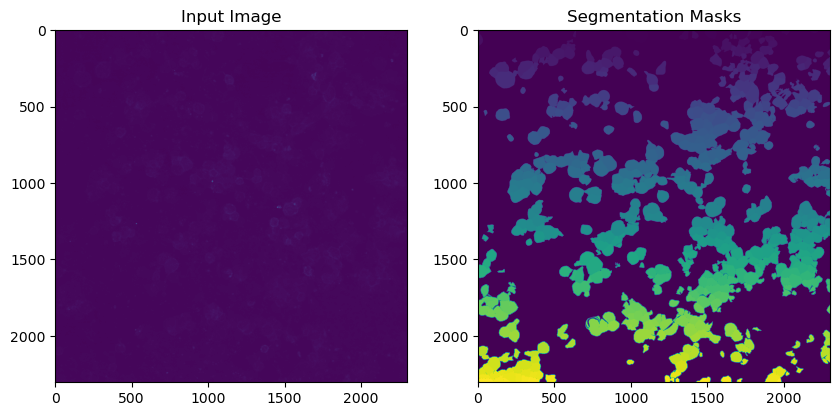

<Labels layer 'masks [13]' at 0x7fd8948c3730>

In [77]:
masks, flows, styles, diams = model.eval(
    cd_frame,  # input image to segment
    diameter=60,  # set average cell diameter (if left to None then it estimates for you)
    flow_threshold=0.99,  # optional parameter to increase if cells undersegmented
    channels=channels,  # channel input defined above, 
    cellprob_threshold = -2, 
)

masks = remove_small_objects(masks, min_size=500)
print(f"Estimated average mask diameter is: {diams:.2f}") # print the estimated cell diameter 

# Display input image and masks
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.imshow(cd_frame)
ax1.set_title("Input Image")
ax2.imshow(masks)
ax2.set_title("Segmentation Masks")
plt.show()
viewer.add_labels(masks)

In [57]:
import numpy as np

In [61]:
np.pi*60**2

11309.733552923255

In [59]:
np.sum([masks == 789])

1024

In [68]:
np.sum([masks == 505])

4457

In [65]:
from skimage.measure import regionprops

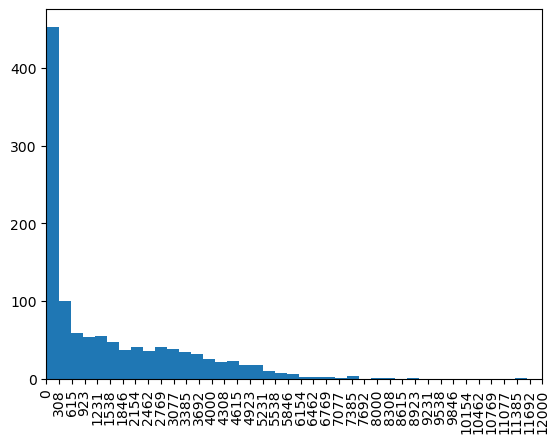

In [75]:
plt.hist([prop.area for prop in regionprops(masks)], bins=40)
plt.xlim(0, 12000)
plt.xticks(np.linspace(plt.xlim()[0], plt.xlim()[1], 40), rotation = 90)  # Change 10 to however many ticks you want
plt.show()

## Now run over whole z-slice

In [78]:
image.shape

(93, 2304, 2304, 4)

In [82]:
mask_array = np.zeros_like(image[...,2])

In [132]:
intensities = []
for n, frame in tqdm(enumerate(image[...,2]), total = len(image)):
    frame_int = np.sum(frame)
    intensities.append(frame_int)
# Estimate the background level - for this example, we'll use the minimum value
background_level = np.min(intensities)
# Set threshold to be a certain value above the background - for example, 15% above
threshold = background_level + ((np.max(y)-np.min(y))*0.50)
# Find the points where the curve starts to deviate from the background
start_point = x[np.argmax(y > threshold)]  # first instance
end_point = x[len(x) - np.argmax(y[::-1] > threshold) - 1]  # last instance

  0%|          | 0/93 [00:00<?, ?it/s]

In [133]:
start_point, end_point

(17, 38)

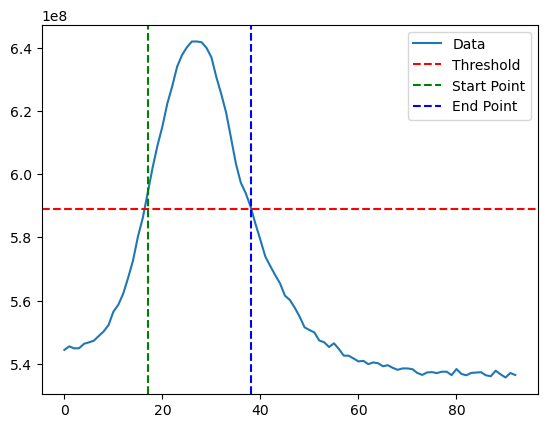

In [130]:
import numpy as np
import matplotlib.pyplot as plt

# Example data
x = range(len(image))
y = cd16_ints #50 * np.exp(-(x**2)/20) + np.random.normal(0, 2, x.size)  # Gaussian curve with noise

# Estimate the background level - for this example, we'll use the minimum value
background_level = np.min(y)

# Set threshold to be a certain value above the background - for example, 15% above
threshold = background_level + ((np.max(y)-np.min(y))*0.50) 

# Find the points where the curve starts to deviate from the background
start_point = x[np.argmax(y > threshold)]  # first instance
end_point = x[len(x) - np.argmax(y[::-1] > threshold) - 1]  # last instance

# Plotting
plt.plot(x, y, label='Data')
plt.axhline(y=threshold, color='r', linestyle='--', label='Threshold')
plt.axvline(x=start_point, color='g', linestyle='--', label='Start Point')
plt.axvline(x=end_point, color='b', linestyle='--', label='End Point')
plt.legend()
plt.show()


In [139]:
intensities = []
for n, frame in tqdm(enumerate(image[...,2]), total = len(image), desc = 'finding where segmentation channel is expressed in Z'):
    frame_int = np.sum(frame)
    intensities.append(frame_int)
# Estimate the background level - for this example, we'll use the minimum value
background_level = np.min(intensities)
# Set threshold to be a certain value above the background - for example, 15% above
threshold = background_level + ((np.max(intensities)-np.min(intensities))*0.50)
# Find the points where the curve starts to deviate from the background
start_point = range(len(image))[np.argmax(intensities > threshold)]  # first instance
end_point = range(len(image))[len(intensities) - np.argmax(intensities[::-1] > threshold) - 1]  # last instance


mphi_mask_array = np.zeros_like(image[...,2])
for n, cd_frame in tqdm(enumerate(image[start_point:end_point,...,2]), 
                        total = len(image[start_point:end_point,...,2]), 
                        desc = 'segmenting over select frames'):
    n = n+start_point
    
    masks, flows, styles, diams = model.eval(
        cd_frame,  # input image to segment
        diameter=60,  # set average cell diameter (if left to None then it estimates for you)
        flow_threshold=0.99,  # optional parameter to increase if cells undersegmented
        channels=channels,  # channel input defined above, 
        cellprob_threshold = -2, 
    )
    
    masks = remove_small_objects(masks, min_size=500)

    mphi_mask_array[n] = masks

finding where segmentation channel is expressed in Z:   0%|          | 0/93 [00:00<?, ?it/s]

segmenting over select frames:   0%|          | 0/21 [00:00<?, ?it/s]

In [141]:
viewer = napari.Viewer(title = 'testing z seg')

viewer.add_image(image, channel_axis = -1)
viewer.add_labels(mask_array)

<Labels layer 'mask_array' at 0x7fd8a9e91790>

In [143]:
print()

# now do a 2 class (mphi and at1)

In [61]:
from tqdm.auto import tqdm
from cellpose import models
from skimage.morphology import remove_small_objects
import numpy as np

def segment_channel(segmentation_channel, diameter=60, flow_threshold=0.99, channels=[0,0], cellprob_threshold=-2, min_mask_size=500, return_diams=False, start_point=None, end_point=None):
    """
    Segments a specified channel of an image using Cellpose and optionally returns the average diameter of segments.

    Args:
    - segmentation_channel (ndarray): 3D array of the target channel where the 3rd dimension represents the Z-stack.
    - diameter (int, optional): Average cell diameter for Cellpose. Default is 60.
    - flow_threshold (float, optional): Threshold for flow in Cellpose. Default is 0.99.
    - channels (list, optional): Channel input for Cellpose. Default is [0,0].
    - cellprob_threshold (float, optional): Cell probability threshold for Cellpose. Default is -2.
    - min_mask_size (int, optional): Minimum size of objects to keep in the segmented mask. Default is 500.
    - return_diams (bool, optional): If set to True, the function will also return the average diameter of segments.
    - start_point (int, optional): Starting point for segmentation frames. Default is None.
    - end_point (int, optional): Ending point for segmentation frames. Default is None.

    Returns:
    - ndarray: 3D mask array with the same shape as the input, where segmented regions are labeled.
    - float (optional): Average diameter of segments if return_diams is True.
    """

    if start_point is None or end_point is None:
        # Calculate intensities for each frame in Z-stack
        intensities = [np.sum(frame) for frame in tqdm(segmentation_channel, desc='finding where segmentation channel is expressed in Z')]

        # Estimate the background level
        background_level = np.min(intensities)
        threshold = background_level + ((np.max(intensities)-np.min(intensities))*0.50)

        if start_point is None:
            # Find the points where the curve starts to deviate from the background
            start_point = np.argmax(intensities > threshold)

        if end_point is None:
            end_point = len(intensities) - np.argmax(intensities[::-1] > threshold) - 1

    # Initialize output mask array
    mask_array = np.zeros_like(segmentation_channel)

    # Initialize the model
    model = models.Cellpose(model_type='cyto')
    
    # List to store diameters if return_diams is True
    diams = []

    # Segment over selected frames
    for n, frame in tqdm(enumerate(segmentation_channel[start_point:end_point]), total=end_point-start_point, desc='segmenting over select frames'):
        n += start_point
        masks, _, _, diam = model.eval(frame, diameter=diameter, flow_threshold=flow_threshold, channels=channels, cellprob_threshold=cellprob_threshold)
        masks = remove_small_objects(masks, min_size=min_mask_size)
        mask_array[n] = masks
        diams.append(diam)

    if return_diams:
        return mask_array, diams
    else:
        return mask_array


In [144]:
zo1_channel = image[...,1]

iat1_masks = segment_channel(zo1_channel, diameter = None, min_mask_size=200)

finding where Mphi segmentation channel is expressed in Z:   0%|          | 0/93 [00:00<?, ?it/s]

segmenting over select frames:   0%|          | 0/22 [00:00<?, ?it/s]

In [187]:
iat2_masks = segment_channel(zo1_channel, 
                             diameter = 150, 
                             min_mask_size=2500, 
                             # start_point=19, 
                             # end_point=23, 
                             cellprob_threshold=-3, 
                             flow_threshold=0.99,
                            )

segmenting over select frames: 100%|█| 4/4 [04:49<00:00, 72.4


In [188]:
viewer.add_labels(iat2_masks)

<Labels layer 'ita2_masks [10]' at 0x7fd78c8e6ee0>

# How to merge iat2 and iat1 segmentation? do not x

In [ ]:
mphi_channel = image[...,2]

mphi_masks, mphi_diams = segment_channel(mphi_channel, 
                                         diameter=60, 
                                         flow_threshold=0.99, 
                                         channels=[0,0], 
                                         cellprob_threshold=-2, 
                                         min_mask_size=200, 
                                         return_diams=True, 
                                         start_point=None, 
                                         end_point=None
                                        )

zo1_channel = image[...,1]

iat2_masks, iat2_diams = segment_channel(zo1_channel, 
                                         diameter=None, 
                                         flow_threshold=0, 
                                         channels=[0,0], 
                                         cellprob_threshold=0, 
                                         min_mask_size=200, 
                                         return_diams=True, 
                                         start_point=17, 
                                         end_point=18
                                        )

iat1_masks, iat1_diams = segment_channel(zo1_channel, 
                                         diameter=150, 
                                         flow_threshold=0.99, 
                                         channels=[0,0], 
                                         cellprob_threshold=-3, 
                                         min_mask_size=2500, 
                                         return_diams=True, 
                                         start_point=None, 
                                         end_point=None
                                        )

In [56]:
import btrack

In [213]:
import importlib

In [9]:
mphi_masks = np.load('mphi_masks.npy')
iat1_masks = np.load('iat1_masks.npy')
iat2_masks = np.load('iat2_masks.npy')

In [36]:
viewer.add_labels(mphi_masks)
viewer.add_labels(iat2_masks)
viewer.add_labels(iat1_masks)

<Labels layer 'iat1_masks' at 0x7f93002d68b0>

In [14]:
btrack.SystemInformation()

btrack_version: 0.6.1.dev116
system_platform: Linux-5.15.0-82-generic-x86_64-with-glibc2.31
system_python: 3.9.17

In [63]:
props = ('axis_major_length', # first define some cell properties 
         'axis_minor_length', # this helps improve the tracking
         'eccentricity',      # by comparing similarities between slices/frames
         'area', 
         'orientation',
         'mean_intensity', 
        )

tracks_dict = {}
napari_tracks_dict = {}
for n, masks in tqdm(enumerate([mphi_masks, iat2_masks, iat1_masks]), total = 3):

    objects = btrack.utils.segmentation_to_objects(
            segmentation = masks, # set the masks here 
            intensity_image = image, # provide the image so that the mean intensity can be measured
            properties = props, # provide the cell properties to improve tracker 
            use_weighted_centroid = False, 
            assign_class_ID=True,
            )
    
    # check if mtb infected above threshold
    threshold = 230
    mtb_ch = 3 # put the mtb channel enumeration in (python indexing-wise])
    for o in tqdm(objects, desc = 'Measuring Mtb properties of each cell'):
        coordinates = np.argwhere(masks[o.t] == o.properties['class_id']) #obj coords (can do using mask to measure class_id with xy coords too)
        pixel_values = image[o.t, coordinates[:, 0], coordinates[:, 1]] # N-channel lists of pixel values
        mtb_status = np.any(pixel_values[:mtb_ch] > threshold)
        mtb_area = np.sum(pixel_values[:mtb_ch] > threshold)
        o.properties['mtb_status'] = mtb_status
        o.properties['mtb_area'] = mtb_area
        o.properties['pixel_values'] = pixel_values


    with btrack.BayesianTracker() as tracker:
            # configure the tracker using a config file
            tracker.configure('/home/dayn/analysis/models/loc.json')
            ### set max search radius to a very limited radius 
            tracker.max_search_radius = 5
            # define tracking method
            tracker.tracking_updates = ["MOTION", "VISUAL"]
            # use visual features to track
            tracker.features = props
            # append the objects to be tracked
            tracker.append(objects)
            # set the volume
            tracker.volume=((0, masks.shape[1]), (0, masks.shape[2]), (-1e5, 1e5))
            # track them (in interactive mode)
            tracker.track(step_size=10)
            # generate hypotheses and run the global optimizer
            tracker.optimize()
            # get the tracks as a python list
            tracks = tracker.tracks

    tracks_dict[n] = tracks
    napari_tracks_dict[n] = btrack.utils.tracks_to_napari(tracks, ndim = 2)

  0%|          | 0/3 [00:00<?, ?it/s]

[INFO][2023/09/05 04:36:27 pm] Localizing objects from segmentation...
[INFO][2023/09/05 04:36:37 pm] Objects are of type: <class 'dict'>
[INFO][2023/09/05 04:36:37 pm] ...Found 11850 objects in 38 frames.


  0%|          | 0/11850 [00:00<?, ?it/s]

[INFO][2023/09/05 04:39:14 pm] Loaded btrack: /home/dayn/analysis/btrack/btrack/libs/libtracker.so
[INFO][2023/09/05 04:39:14 pm] Starting BayesianTracker session
[INFO][2023/09/05 04:39:14 pm] Loading configuration file: /home/dayn/analysis/models/loc.json
[INFO][2023/09/05 04:39:14 pm] Objects are of type: <class 'list'>
[INFO][2023/09/05 04:39:15 pm] Starting tracking... 
[INFO][2023/09/05 04:39:15 pm] Update using: ['VISUAL', 'MOTION']
[INFO][2023/09/05 04:39:15 pm] Tracking objects in frames 0 to 9 (of 38)...
[INFO][2023/09/05 04:39:19 pm]  - Timing (Bayesian updates: 160.30ms, Linking: 4.84ms)
[INFO][2023/09/05 04:39:19 pm]  - Probabilities (Link: 0.99999, Lost: 1.00000)
[INFO][2023/09/05 04:39:19 pm]  - Stats (Active: 1012, Lost: 1168, Conflicts resolved: 2115)
[INFO][2023/09/05 04:39:19 pm] Tracking objects in frames 10 to 19 (of 38)...
[INFO][2023/09/05 04:39:22 pm]  - Timing (Bayesian updates: 43.23ms, Linking: 2.32ms)
[INFO][2023/09/05 04:39:22 pm]  - Probabilities (Link: 1.

GLPK Integer Optimizer 5.0
10812 rows, 8112 columns, 10818 non-zeros
8112 integer variables, all of which are binary
Preprocessing...
5406 rows, 8112 columns, 10818 non-zeros
8112 integer variables, all of which are binary
Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Problem data seem to be well scaled
Constructing initial basis...
Size of triangular part is 5406
Solving LP relaxation...
GLPK Simplex Optimizer 5.0
5406 rows, 8112 columns, 10818 non-zeros
*     0: obj =   3.226469357e+04 inf =   0.000e+00 (2285)
*  2287: obj =   1.202945578e+04 inf =   0.000e+00 (0)
OPTIMAL LP SOLUTION FOUND
Integer optimization begins...
Long-step dual simplex will be used
+  2287: mip =     not found yet >=              -inf        (1; 0)
+  2287: >>>>>   1.202945578e+04 >=   1.202945578e+04   0.0% (1; 0)
+  2287: mip =   1.202945578e+04 >=     tree is empty   0.0% (0; 1)
INTEGER OPTIMAL SOLUTION FOUND


[INFO][2023/09/05 04:39:23 pm] Localizing objects from segmentation...
[INFO][2023/09/05 04:39:25 pm] Objects are of type: <class 'dict'>
[INFO][2023/09/05 04:39:25 pm] ...Found 5157 objects in 23 frames.


  0%|          | 0/5157 [00:00<?, ?it/s]

[INFO][2023/09/05 04:40:35 pm] Loaded btrack: /home/dayn/analysis/btrack/btrack/libs/libtracker.so
[INFO][2023/09/05 04:40:35 pm] Starting BayesianTracker session
[INFO][2023/09/05 04:40:35 pm] Loading configuration file: /home/dayn/analysis/models/loc.json
[INFO][2023/09/05 04:40:35 pm] Objects are of type: <class 'list'>
[INFO][2023/09/05 04:40:35 pm] Starting tracking... 
[INFO][2023/09/05 04:40:35 pm] Update using: ['VISUAL', 'MOTION']
[INFO][2023/09/05 04:40:35 pm] Tracking objects in frames 0 to 9 (of 23)...
[INFO][2023/09/05 04:40:39 pm]  - Timing (Bayesian updates: 486.28ms, Linking: 8.77ms)
[INFO][2023/09/05 04:40:39 pm]  - Probabilities (Link: 1.00000, Lost: 1.00000)
[INFO][2023/09/05 04:40:39 pm] SUCCESS.
[INFO][2023/09/05 04:40:39 pm]  - Found 1555 tracks in 23 frames (in 0.0s)
[INFO][2023/09/05 04:40:39 pm]  - Inserted 312 dummy objects to fill tracking gaps
[INFO][2023/09/05 04:40:39 pm] Loading hypothesis model: particle_hypothesis
[INFO][2023/09/05 04:40:39 pm] Calculat

GLPK Integer Optimizer 5.0
6220 rows, 4676 columns, 6242 non-zeros
4676 integer variables, all of which are binary
Preprocessing...
3110 rows, 4676 columns, 6242 non-zeros
4676 integer variables, all of which are binary
Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Problem data seem to be well scaled
Constructing initial basis...
Size of triangular part is 3110
Solving LP relaxation...
GLPK Simplex Optimizer 5.0
3110 rows, 4676 columns, 6242 non-zeros
*     0: obj =   1.144417147e+04 inf =   0.000e+00 (959)
*   965: obj =   6.635105028e+03 inf =   0.000e+00 (0)
OPTIMAL LP SOLUTION FOUND
Integer optimization begins...
Long-step dual simplex will be used
+   965: mip =     not found yet >=              -inf        (1; 0)
+   965: >>>>>   6.635105028e+03 >=   6.635105028e+03   0.0% (1; 0)
+   965: mip =   6.635105028e+03 >=     tree is empty   0.0% (0; 1)
INTEGER OPTIMAL SOLUTION FOUND


[INFO][2023/09/05 04:40:39 pm] Localizing objects from segmentation...
[INFO][2023/09/05 04:40:41 pm] Objects are of type: <class 'dict'>
[INFO][2023/09/05 04:40:41 pm] ...Found 532 objects in 23 frames.


  0%|          | 0/532 [00:00<?, ?it/s]

[INFO][2023/09/05 04:40:48 pm] Loaded btrack: /home/dayn/analysis/btrack/btrack/libs/libtracker.so
[INFO][2023/09/05 04:40:48 pm] Starting BayesianTracker session
[INFO][2023/09/05 04:40:48 pm] Loading configuration file: /home/dayn/analysis/models/loc.json
[INFO][2023/09/05 04:40:48 pm] Objects are of type: <class 'list'>
[INFO][2023/09/05 04:40:48 pm] Starting tracking... 
[INFO][2023/09/05 04:40:48 pm] Update using: ['VISUAL', 'MOTION']
[INFO][2023/09/05 04:40:48 pm] Tracking objects in frames 0 to 9 (of 23)...
[INFO][2023/09/05 04:40:48 pm]  - Timing (Bayesian updates: 5.09ms, Linking: 1.07ms)
[INFO][2023/09/05 04:40:48 pm]  - Probabilities (Link: 1.00000, Lost: 1.00000)
[INFO][2023/09/05 04:40:48 pm] SUCCESS.
[INFO][2023/09/05 04:40:48 pm]  - Found 290 tracks in 23 frames (in 0.0s)
[INFO][2023/09/05 04:40:48 pm]  - Inserted 23 dummy objects to fill tracking gaps
[INFO][2023/09/05 04:40:48 pm] Loading hypothesis model: particle_hypothesis
[INFO][2023/09/05 04:40:49 pm] Calculating 

GLPK Integer Optimizer 5.0
1160 rows, 870 columns, 1160 non-zeros
870 integer variables, all of which are binary
Preprocessing...
580 rows, 870 columns, 1160 non-zeros
870 integer variables, all of which are binary
Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Problem data seem to be well scaled
Constructing initial basis...
Size of triangular part is 580
Solving LP relaxation...
GLPK Simplex Optimizer 5.0
580 rows, 870 columns, 1160 non-zeros
*     0: obj =   2.058450914e+03 inf =   0.000e+00 (263)
*   263: obj =   8.014849766e+02 inf =   0.000e+00 (0)
OPTIMAL LP SOLUTION FOUND
Integer optimization begins...
Long-step dual simplex will be used
+   263: mip =     not found yet >=              -inf        (1; 0)
+   263: >>>>>   8.014849766e+02 >=   8.014849766e+02   0.0% (1; 0)
+   263: mip =   8.014849766e+02 >=     tree is empty   0.0% (0; 1)
INTEGER OPTIMAL SOLUTION FOUND


# Saveout

In [65]:
tracks[0]

,ID,t,x,y,z,parent,root,state,generation,dummy,axis_major_length,axis_minor_length,mtb_status,orientation,class_id,mean_intensity,eccentricity,mtb_area,area
0,102,19,316.399593,123.789123,0.0,102,102,5,0,False,"(1,) array","(1,) array","(1,) array","(1,) array","(1,) array","(1, 4) array","(1,) array","(1,) array","(1,) array"


In [73]:
tracks_dict.keys()

dict_keys([0, 1, 2])

In [78]:
output_fn = os.path.join(f'test.h5')

In [79]:
# Using the keys() method
for key in tracks_dict.keys():

    obj_type = f'obj_type_{key+1}'
    with btrack.io.HDF5FileHandler(output_fn, 
                                       'w', 
                                       obj_type=obj_type
                                       ) as writer:
            writer.write_tracks(tracks_dict[key])
            writer.write_segmentation(mphi_masks)

[INFO][2023/09/05 04:48:14 pm] Opening HDF file: test.h5...
[INFO][2023/09/05 04:48:14 pm] Writing objects/obj_type_1
[INFO][2023/09/05 04:48:14 pm] Writing labels/obj_type_1
[INFO][2023/09/05 04:48:14 pm] Loading objects/obj_type_1 (5898, 5) (5898 filtered: None)
[INFO][2023/09/05 04:48:14 pm] Writing properties/obj_type_1/axis_major_length (5898,)
[INFO][2023/09/05 04:48:14 pm] Writing properties/obj_type_1/axis_minor_length (5898,)
[INFO][2023/09/05 04:48:14 pm] Writing properties/obj_type_1/eccentricity (5898,)
[INFO][2023/09/05 04:48:14 pm] Writing properties/obj_type_1/area (5898,)
[INFO][2023/09/05 04:48:14 pm] Writing properties/obj_type_1/orientation (5898,)
[INFO][2023/09/05 04:48:14 pm] Writing properties/obj_type_1/mean_intensity (5898, 4)
[INFO][2023/09/05 04:48:14 pm] Writing properties/obj_type_1/class_id (5898,)
[INFO][2023/09/05 04:48:14 pm] Writing properties/obj_type_1/mtb_status (5898,)
[INFO][2023/09/05 04:48:14 pm] Writing properties/obj_type_1/mtb_area (5898,)
[I

In [70]:
output_fn = os.path.join(f'test.h5')

for key in tracks_dict.keys()

    obj_type = f'obj_type_{key}'
    # save out 
    with btrack.io.HDF5FileHandler(output_fn, 
                                       'w', 
                                       obj_type=obj_type
                                       ) as writer:
            writer.write_tracks(tracks_dict[key])
            writer.write_segmentation(mphi_masks)

SyntaxError: invalid syntax (2980934840.py, line 3)

In [66]:
tracks_dict

{0: [OrderedDict([('ID', 351), ('t', [17]), ('x', [1890.460024600246]), ('y', [11.92250922509225]), ('z', [0.0]), ('parent', 351), ('root', 351), ('state', [5]), ('generation', 0), ('dummy', [False]), ('axis_major_length', array([42.59979008])), ('axis_minor_length', array([26.51165964])), ('mtb_status', array([False])), ('orientation', array([-1.05130811])), ('class_id', array([18.])), ('mean_intensity', array([[751.06396064, 117.6900369 , 107.2902829 , 110.87699877]])), ('eccentricity', array([0.78274505])), ('mtb_area', array([0])), ('area', array([813.]))]),
  OrderedDict([('ID', 343), ('t', [17, 18, 19]), ('x', [1554.4770246984492, 1554.4770246984492, 1558.5545023696682]), ('y', [201.87449741527857, 201.87449741527857, 204.37730384412848]), ('z', [0.0, 0.0, 0.0]), ('parent', 343), ('root', 343), ('state', [5, 5, 5]), ('generation', 0), ('dummy', [False, True, False]), ('axis_major_length', array([76.16241516,         nan, 85.59628029])), ('axis_minor_length', array([60.80276852,  